# Digit classification with the Kernel Perceptron


Shaikyp Ulan (944462)

Download the MNIST dataset for multiclass classification of handwritten digits. Implement the kernel Perceptron from scratch and run it to train 10 binary classifiers, one for each of the 10 digits (one-vs-all encoding), using the polynomial kernel. In order to extract a binary classifier, do the following: run the algorithm for a given number of epochs (e.g., cycles over the entire training data) on a random permutation of the training set and collect the ensemble of predictorsused by the Perceptron when predicting each training datapoint . Then use:

* the average of the predictors in the ensemble;
* the predictor achieving the smallest training error among those in the ensemble.

Based on the given split of the data in training and test set, evaluate the multiclass classification performance (zero-one loss) for different values of the number of epochs (go up to at least 10 epochs) and the degree of the polynomial (go up to at least degree 6). In order to use the 10 binary classifiers to make multiclass predictions, use the fact that binary classifiers trained by the Perceptron have the form  and predict using  wherecorresponds to the binary classifier for class.

# Import data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Overview

MNIST Handwritten Digits dataset is used for this task. It contains images of digits taken from a variety of scanned documents, normalized in size and centered. This makes it an excellent dataset for evaluating models, allowing the developer to focus on the machine learning with very little data cleaning or preparation required. Each image is a 28 by 28 pixel square (784 pixels total). The dataset contains 60,000 images for model training and 10,000 images for the evaluation of the model.

The dataset consists of two files:

* mnist_train.csv - contains 60,000 training examples and labels
* mnist_test.csv - contains 10,000 test examples and labels

The first value in the dataset is the label (a number from 0 to 9) and the remaining 784 values are the pixel values (a number from 0 to 255).

In [19]:
mnist_train = pd.read_csv('mnist_train.csv', delimiter=',')
mnist_test = pd.read_csv('mnist_test.csv', delimiter=',')

In [20]:
mnist_train = mnist_train.sample(frac = 1)

In [21]:
X = mnist_train.iloc[:,1:].to_numpy()
y = mnist_train.iloc[:,0]
X_test = mnist_test.iloc[:,1:].to_numpy()
y_test = mnist_test.iloc[:,0]

In [22]:
X = X/255
X_test = X_test/255

In [23]:
print(mnist_train.info())
# mnist_train.describe()
mnist_train.isnull().any().describe()  # No missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 15949 to 23580
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.8 MB
None


count       785
unique        1
top       False
freq        785
dtype: object

In [24]:
mnist_train.head(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
15949,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31729,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32578,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47077,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Dataset is pretty balanced!


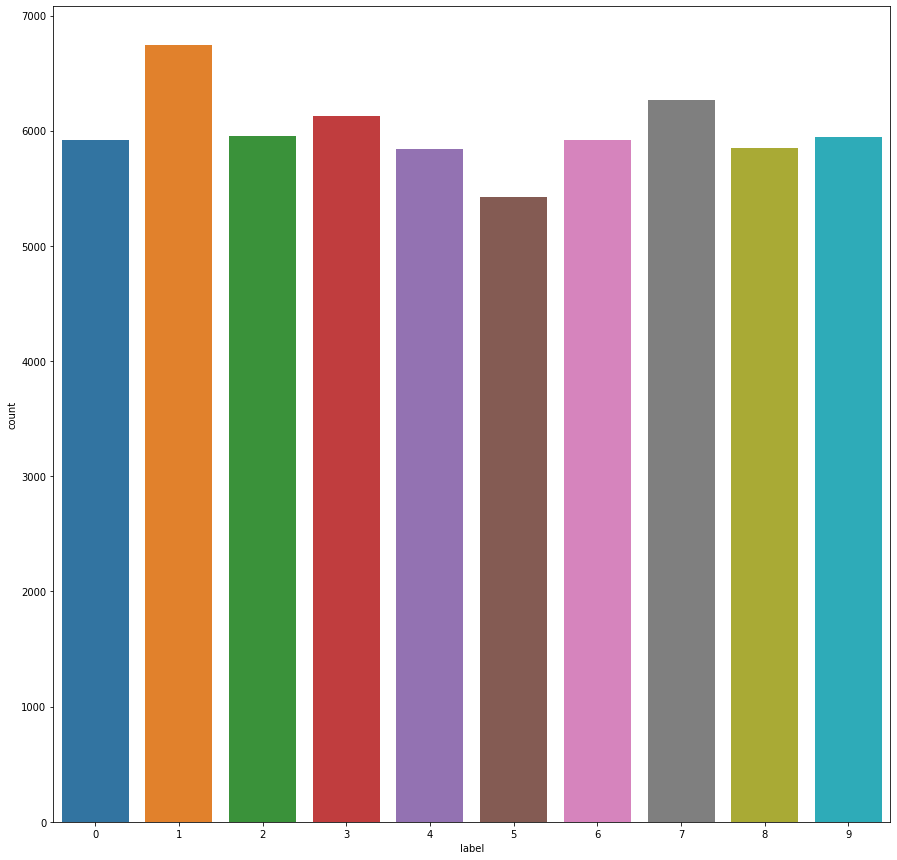

In [25]:
# Countplot for labels
sns.countplot(mnist_train['label'])
print("Dataset is pretty balanced!")

In [26]:
print(mnist_test.info())
mnist_test.isnull().any().describe() # No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 59.9 MB
None


count       785
unique        1
top       False
freq        785
dtype: object

In [27]:
mnist_test.head(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


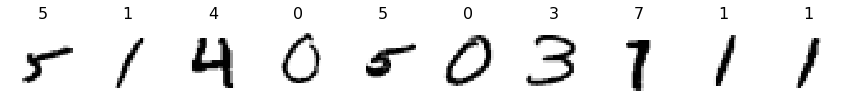

In [28]:
# create a temporary DataFrame for visualization purposes
plot_ten_df = mnist_train.drop("label", axis=1).iloc[0:10, :]
plt.rcParams['figure.figsize'] = [15, 15]

# visualize the first 10 digits in the train set 
for index in range(10):
    plt.subplot(1, 10, index+1)
    # reshape pixel arragement to 28 x 28
    digit_array = np.asarray(plot_ten_df.iloc[index]).reshape(28, 28)
    plt.imshow(digit_array, cmap="binary")
    plt.title(mnist_train["label"].iloc[index], fontsize=16)
    plt.axis("off")

## Polynomial kernel

In [29]:
def polynomial_kernel(X, y, p):
    return (1 + X @ y.T) ** p

In [30]:
def multiclass(X, y, T, D):
    
    n_class = y.unique()
    
    S_list = []
    y_S_list = []
    index_list = []
    
    for c in range(len(n_class)):
    
        print('Appropriate number', c )
        y_class = np.where(y == c,1,-1)
        S = X[0]
        y_S = y_class[0]
        index = 0
    
        for t in range(T):
            for j in range(X.shape[0] - 1):
                if np.sign(np.sum(y_S.T * ((1 + S @ X[j+1])**D))) != y_class[j+1]:
                    S = np.vstack([S, X[j+1]])
                    y_S = np.vstack([y_S, y_class[j+1]])
                    index = np.vstack([index,((j+1)+X.shape[0]*t)])
                
        S_list.append(S)
        y_S_list.append(y_S)
        index_list.append(index)
        
    return S_list, y_S_list, index_list

In [31]:
def average_predictors(S, y_S, index, X, T):
    S_avg_list = []
    y_S_avg_list = []
    
    for i in range(len(S)):
        weight = S[i] * (((X.shape[0]*(T))-index[i])/(X.shape[0]*(T)))
        y_weight = y_S[i] * (((X.shape[0]*(T))-index[i])/(X.shape[0]*(T)))
        S_avg_list.append(weight)
        y_S_avg_list.append(y_weight)
        
    return S_avg_list, y_S_avg_list

# Binary Classification

## Average Predictor

In [32]:
epochs = 4
deg = [3,4,5,6,7,8,9,10]
binary_result_test = []
binary_result_train = []
for d in deg:
    print('Multi class for T =' , epochs, 'degree =',d)
    S, y_S, index = multiclass(X,y, T = epochs, D = d)
    avg, y_avg = average_predictors(S, y_S, index, X, T = epochs)
    print('Start prediction!')
        
    for c in range(len(avg)):
        y_test_class = np.where(y_test == c,1,-1)
        y_train_class = np.where(y == c, 1,-1)
        p = np.sign(np.sum(y_avg[c] * polynomial_kernel(avg[c],X_test, p = d),axis=0))
        r = np.count_nonzero(p - y_test_class)/10000
        binary_result_test.append(r)
        p = np.sign(np.sum(y_avg[c] * polynomial_kernel(avg[c],X, p = d),axis=0))
        r = np.count_nonzero(p - y_train_class)/60000
        binary_result_train.append(r)

Multi class for T = 4 degree = 3
Appropriate number 0
Appropriate number 1
Appropriate number 2
Appropriate number 3
Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate number 8
Appropriate number 9
Start prediction!
Multi class for T = 4 degree = 4
Appropriate number 0
Appropriate number 1
Appropriate number 2
Appropriate number 3
Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate number 8
Appropriate number 9
Start prediction!
Multi class for T = 4 degree = 5
Appropriate number 0
Appropriate number 1
Appropriate number 2
Appropriate number 3
Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate number 8
Appropriate number 9
Start prediction!
Multi class for T = 4 degree = 6
Appropriate number 0
Appropriate number 1
Appropriate number 2
Appropriate number 3
Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate numb

Enter your number: 5


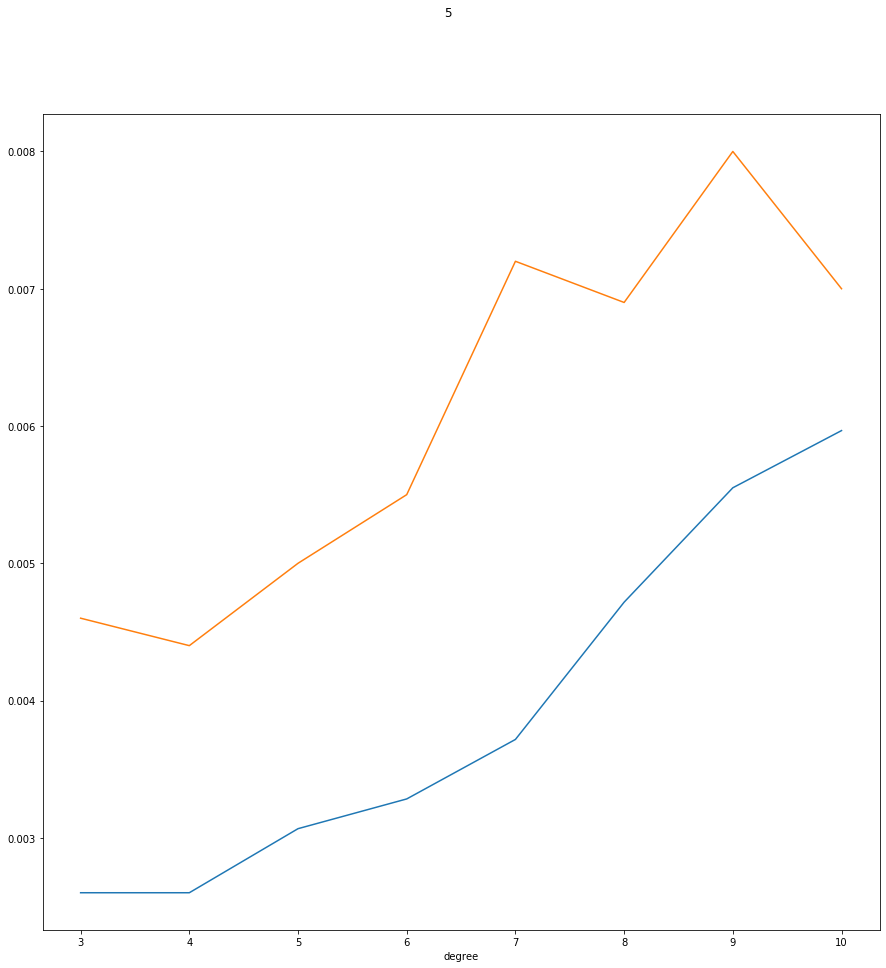

In [33]:
deg = [3,4,5,6,7,8,9,10]
n = input("Enter your number: ")


fig = plt.figure()
plt.plot(deg, binary_result_train[int(n):80:10], label = "Train Error", )
plt.plot(deg, binary_result_test[int(n):80:10], label = "Test Error")
fig.suptitle(str(n))
plt.xlabel('degree')
#plt.savefig(n + 'avg.eps', format='eps')
plt.show()

# Best Predictor

In [34]:
S, y_S, index = multiclass(X,y, T = 3, D = 3)

Appropriate number 0
Appropriate number 1
Appropriate number 2
Appropriate number 3
Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate number 8
Appropriate number 9


In [35]:
n = input("Enter your number: ")

binary_result_train_all = []
binary_result_test_all = []

kernel_train = polynomial_kernel(S[int(n)],X, p = 3)
kernel_test = polynomial_kernel(S[int(n)],X_test, p = 3)
y_class = y_S[int(n)]
y_train_class = np.where(y == int(n), 1, -1)
y_test_class = np.where(y_test == int(n), 1, -1)

for h in range(kernel_train.shape[0]):
    p = np.sign(np.sum(y_class[:h] * kernel_train[:h],axis=0))
    binary_result_train_all.append(np.count_nonzero(p - y_train_class))

for h in range(kernel_test.shape[0]):
    p = np.sign(np.sum(y_class[:h] * kernel_test[:h],axis=0))
    binary_result_test_all.append(np.count_nonzero(p - y_test_class))

Enter your number: 8


In [36]:
min_train = binary_result_train_all.index(min(binary_result_train_all))
min_test = binary_result_test_all.index(min(binary_result_test_all))

In [37]:
print(min(binary_result_train_all)/60000, min_train)
print(min(binary_result_test_all)/10000, min_test)

0.0023333333333333335 2061
0.0065 1840


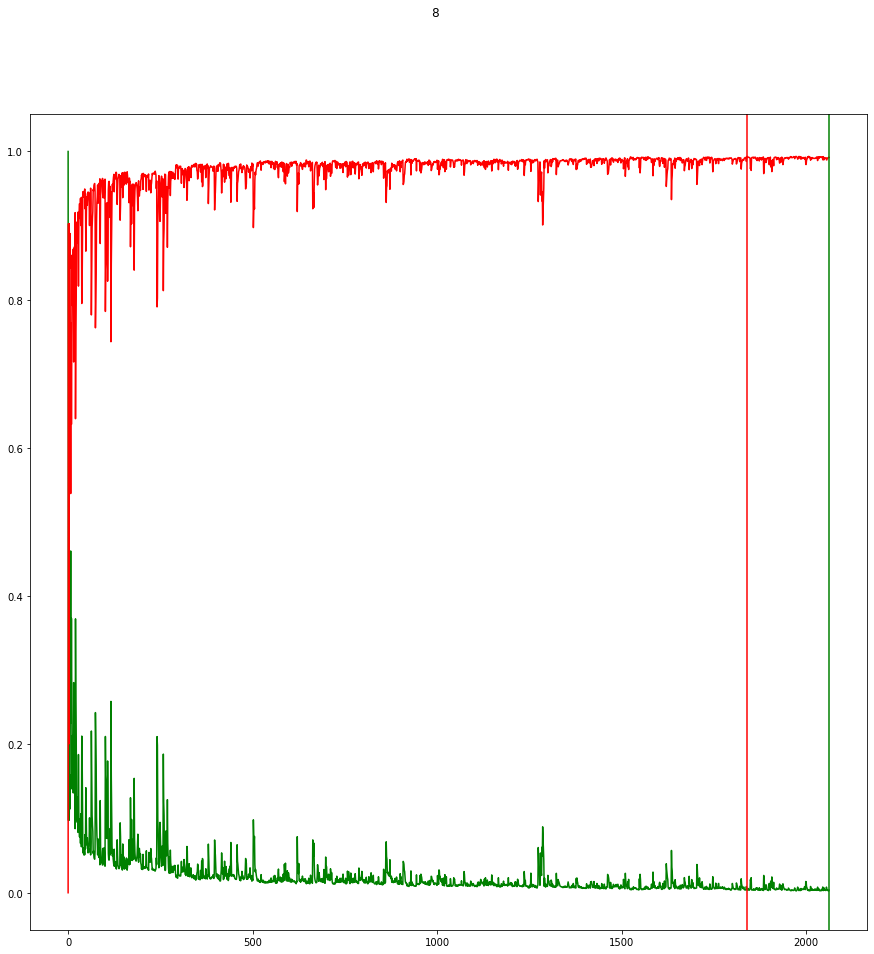

In [38]:
fig = plt.figure()
plt.plot(np.array(binary_result_train_all)/60000, label = "Train Error", color = "green")
plt.plot(1 - (np.array(binary_result_test_all)/10000), label = "Test Error", color = "red")
plt.axvline(x = min_train, color = "green")
plt.axvline(x = min_test, color = "red")
fig.suptitle(str(n))
#plt.savefig(n + 'best.eps', format='eps')
plt.show()

# Multiclass Classification

In [ ]:
epo = [1,2,3,4,5,6,7,8,9,10]
deg = [1,2,3,4,5,6]

results = []

for e in epo:
    for d in deg: 
        print('Multi class for T =' , e, 'degree =',d)
        S, y_S, index = multiclass(X,y, T = e, D = d)
        avg, y_avg = average_predictors(S, y_S, index, X, T = e)
        projections = []
        print('Start prediction!')
        
        for c in range(len(avg)): 
            p = np.sum(y_avg[c] * polynomial_kernel(avg[c],X_test, p = d),axis=0)
            projections.append(p)
            
        projectionst = pd.DataFrame(projections).T
        y_hat = projectionst.idxmax(axis = 1)
        results.append(np.count_nonzero(y_hat - y_test))

Multi class for T = 1 degree = 1
Appropriate number 0
Appropriate number 1
Appropriate number 2
Appropriate number 3
Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate number 8
Appropriate number 9
Start prediction!
Multi class for T = 1 degree = 2
Appropriate number 0
Appropriate number 1
Appropriate number 2
Appropriate number 3
Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate number 8
Appropriate number 9
Start prediction!
Multi class for T = 1 degree = 3
Appropriate number 0
Appropriate number 1
Appropriate number 2
Appropriate number 3
Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate number 8
Appropriate number 9
Start prediction!
Multi class for T = 1 degree = 4
Appropriate number 0
Appropriate number 1
Appropriate number 2
Appropriate number 3
Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate numb

Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate number 8
Appropriate number 9
Start prediction!
Multi class for T = 6 degree = 3
Appropriate number 0
Appropriate number 1
Appropriate number 2
Appropriate number 3
Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate number 8
Appropriate number 9
Start prediction!
Multi class for T = 6 degree = 4
Appropriate number 0
Appropriate number 1
Appropriate number 2
Appropriate number 3
Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate number 8
Appropriate number 9
Start prediction!
Multi class for T = 6 degree = 5
Appropriate number 0
Appropriate number 1
Appropriate number 2
Appropriate number 3
Appropriate number 4
Appropriate number 5
Appropriate number 6
Appropriate number 7
Appropriate number 8
Appropriate number 9
Start prediction!
Multi class for T = 6 degree = 6
Appropriate number 0
Appropriate number 

In [ ]:
#results = pd.read_csv('results.csv', header = None)
results = results/10000

In [ ]:
sns.set_theme()

for i in range(len(epochs_list)):
    sns.lineplot(x=deg, y=results[i*4:(i+1)*4], label=f'epochs={epo[i]}')

plt.title('Errors on epochs and degrees')
plt.ylabel('Error')
plt.xlabel('Degree')
plt.legend()